# This Notebook Contains All EDA, Pre-Processing, Model Performance and Evaluations

### Enviornments Used:
- TensorFlow
- Streamlit

In [1]:
# Standard Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow & Keras Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Rest of Imports
import cv2
from PIL import Image
from skimage import transform
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Denoting Paths, Data is already labeled and organized
train_path = 'data/train/'
test_path = 'data/test/'
valid_path = 'data/valid/'

## Checking Images

In [3]:
def display_sample(data_path,img_class): # function to display images of desired data

    path_class = ['cancer', 'non_cancer'] # class of each data set

    path_list = []

    # creating a dataframe out of train, valid, and test folders
    for index, sp in enumerate(path_class):
        for file in os.listdir(os.path.join(data_path, sp)):
            path_list.append([sp + "/" + file, index, sp])
    
    # DataFrame is now ready to be called and plotted 
    data_path_frame = pd.DataFrame(path_list, columns = ['File', 'ID','Class'])
    
    fig, ax = plt.subplots(3,3,figsize=(8,8))
    df_files = data_path_frame['File'][data_path_frame['Class'] == img_class].values
    
    n = 0 # starting at first row of dataframe
    fig.suptitle(img_class.capitalize(), fontsize = 14, color = "Black")
    for i in range(3):
        for j in range(3):
            image_path = os.path.join(data_path, df_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1 # once the first image is pulled the counter will advance to the next image

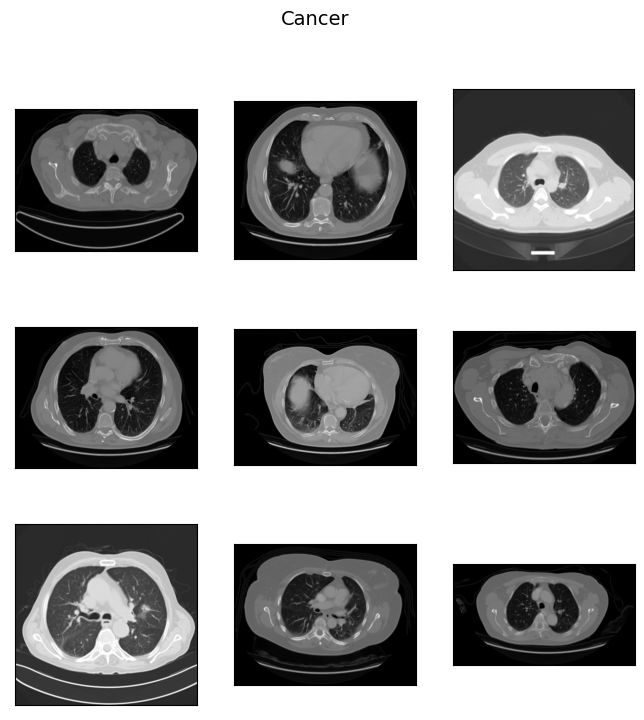

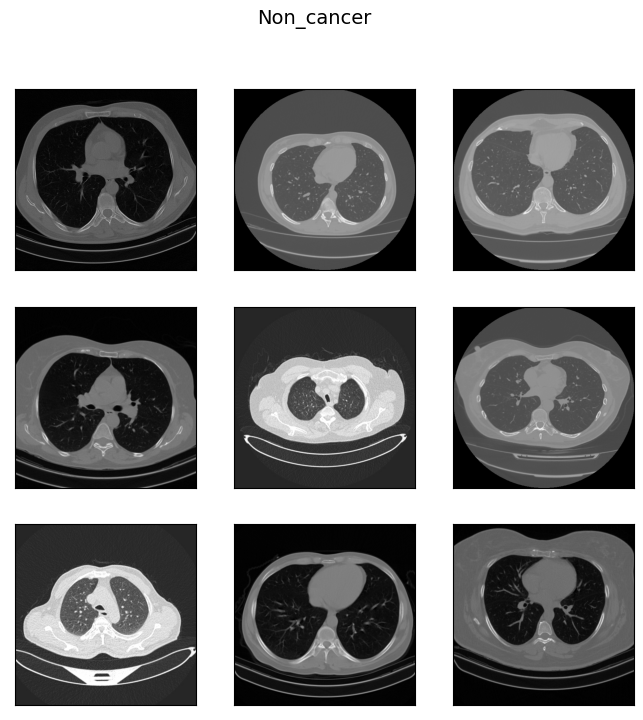

In [4]:
display_sample(valid_path,'cancer') # first 9 images display ct scans with cancer
display_sample(train_path,'non_cancer') # last 9 images do not display cancer

## EDA Overview:
- After initially cleaning and reviewing my data, I constructed several models to evaluate early performances. Upon evaluation, I discovered severe overfitting of my data. 
- After performing a misclassification analysis, I discovered that many images were duplicates despite having different file names. Additionally, I discovered I had several mislabeled images that I had overlooked during my first sweep of the data. 
- To counter overfitting, I prioritized gathering more data. Subsequently, I reviewed every image to ensure there were no duplicates and finally relabeled any misplaced images. With 2000 training images, 400 validation images, and 80 testing images, split 50/50 respectively, I am ready to construct more models.

## Pre-Processing

In [5]:
train_gen = ImageDataGenerator(
    rescale=None, # no need to rescale as images are already scaled 0-1
    rotation_range=40, # range for random rotations
    width_shift_range=.1, # at random will shift width
    height_shift_range=.1, # at random will shift height
    zoom_range=.1, # range for random zooms
    horizontal_flip=False, # False is default
    vertical_flip=False) # False is default

test_gen = ImageDataGenerator(rescale=None)


valid_gen = ImageDataGenerator(rescale=None)

In [6]:
# will use binary and grayscale for all images
train_data = train_gen.flow_from_directory(
    train_path,
    class_mode='binary',
    color_mode='grayscale') 

valid_data = valid_gen.flow_from_directory(
    valid_path,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False)
    
test_data = test_gen.flow_from_directory(
    test_path,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False)
# setting suffle to False on test only 
# Test samples don’t get shuffled as to get consistent label assignment/alphanumeric 
# order as the validation classes

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [7]:
# Checking all sizes are the same
print(train_data.image_shape)
print(valid_data.image_shape)
print(test_data.image_shape)
# ensuring .gitignore is working and indcies contain no .checkpoints
train_data.class_indices 

(256, 256, 1)
(256, 256, 1)
(256, 256, 1)


{'cancer': 0, 'non_cancer': 1}

## Examining Distribution of Data and Establishing Baseline

In [8]:
def image_distribution(data):
    
    # height variable is array count of each class
    height = np.unique(data.classes,return_counts=True)[1] # indexing array which contains image counts

    fig, ax = plt.subplots(figsize=(6,4))
    
    # able to call upon any set of data with method used
    ax.bar(x=['Cancer','Non-Cancer'],height=height,
    width=.4,color=['thistle','lightblue'])

    plt.title(f"Images In Each Class of {str(data.directory).split('/')[1].capitalize()} Data")
    plt.xlabel('Class')
    plt.ylabel('Image Count')
    plt.ylim(top=height[0]+60) # 60 above top to give annotations space
    plt.bar_label(ax.containers[0]);

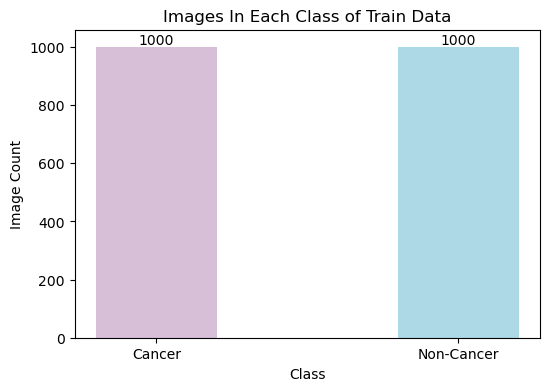

In [9]:
image_distribution(train_data)

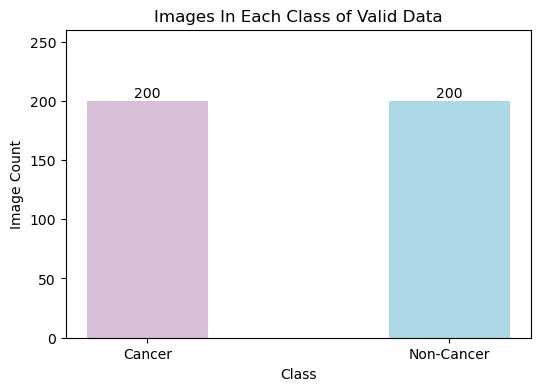

In [10]:
image_distribution(valid_data)

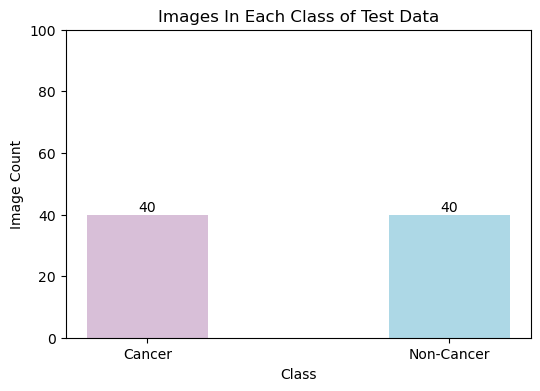

In [11]:
image_distribution(test_data)

## Baseline:
-	As seen in the histograms, the data is distributed amongst a training, validation, and testing set. Each set contains two classes, 50% of the images have cancer and 50% do not have cancer. Classifying 50% of the images accurately is the baseline for any model.
-	Given this is a medical dataset, it is important to optimize for false negatives. In practice, you’d want to tell your patient they have cancer when they do not compared to the opposite.
-	Therefore, I want my model to demonstrate high accuracy and recall.

## Modeling Overview
- An early goal was to create a custom model that could compete with transfer learning models however I was unsuccessful. After constructing many models, my best custom model was the fourth I constructed. 
- Initially, the model was scoring around 85% accuracy at best. After making pre-processing adjustments such as adding random rotation, height, and width shifts, my model performance improved slightly. Placing the Batch Normalization layer before the activation layer and increasing the dropout rate from 20% to 30%, increased my model performance. Results follow model construction.  
- Despite mentioned and many unmentioned regularization methods, I couldn't construct a custom model that could compete with transfer learning models such as ResNet50 or the VGG16.
- Epochs and summaries were removed in favor of condensing the notebook.

## Model 4 Construction

In [12]:
# instantiating model
model4 = tf.keras.models.Sequential([
    
    # Input Layer
    # Greyscale input requires 1 channel alongside image size, filters at 16 to avoid overfitting
    tf.keras.layers.Conv2D(input_shape=(256,256,1),padding='same',filters=16,kernel_size=(3,3)),
    tf.keras.layers.BatchNormalization(), # BatchNorm prior to activation yields better results
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(2,padding='same'), 
    # padding evenly across the input so that the output has the same height/width dimension as the input
    # models performed consistently better with padding = same
    
    # Hidden Layer
    tf.keras.layers.Dense(64), # 64 neurons, on the lower side to avoid overfitting 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(.3), # adding a dropout layer of 30% to counter overfitting
    tf.keras.layers.MaxPool2D(2,padding='same'),
    
    # Output Layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Activation('sigmoid') # every output for every model will be sigmoid
])
# can ignore warning

2022-10-14 18:13:38.529313: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
opt = keras.optimizers.Adam(learning_rate=0.01)  # .001 is default

model4.compile(loss='binary_crossentropy', 
               optimizer=opt, metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0.03,
    verbose=1, 
    patience=10) 

In [14]:
history4 = model4.fit(
    train_data,
    batch_size=16, # halving batch size to counter overfitting
    validation_data=valid_data,
    epochs=30,
    callbacks=[early_stop])
# reiterating that epochs and model summaries are removed to condense notebook

In [15]:
model4.save("models/model4.h5")

## Model 4 Predictions and Results

In [16]:
model4 = load_model('models/model4.h5')

In [17]:
# creating function to return classification report, confusion matrix,
# misclassified images, and distribution of classified images

# arguments are: desired model, the data to run the model on, and path associated with data
def model_results(model,data,path):
    
    y_pred = model.predict(data) # predictions on the model
    
    predictions = [] # predictions returns probabilities from 0-1, I will append all predictions to a list
    for each in y_pred:
        for num in each:
            # 0 is cancer, 1 is non-cancer
            if num <= .5: # including .5 to potentially minimize false negatives
                predictions.append(0)
            else:
                predictions.append(1)
    
    plt.hist(predictions) # plotting histogram of predictions
    plt.title('Classification results')
    plt.xlabel('Cancer: 0     Non_Cancer: 1')
    plt.xticks([0,1])
    plt.ylabel('Quantity Classified')
    
    print(classification_report(data.classes,predictions))
    # data.classes allows for any of train,valid,test to be called upon
    c_matrix = confusion_matrix(data.classes,predictions)
    
    display = ConfusionMatrixDisplay(c_matrix).plot() # displaying saved confusion matrix
    
    plt.show()
    
    # MISCLASSIFICATION
    path_class = ['cancer', 'non_cancer'] # designating paths similarly to earlier function

    path_list = [] # list to append probablities to

    for index, sp in enumerate(path_class):
        for file in os.listdir(os.path.join(path, sp)):
            path_list.append([sp + "/" + file, index, sp])
    
    # argument for data will be easier to misclassify by putting path argument in dataframe
    misclass = pd.DataFrame(path_list, columns = ['File', 'Id','Class'])
    misclass['Predictions'] = predictions
    
    # Where Id does not equal Predictions are the misclassified images. The file allows to pull the image
    img_misclass = misclass['File'][misclass['Id']!=misclass['Predictions']].values
    img_misclass_type = misclass['Class'][misclass['Id']!=misclass['Predictions']].values
    
    # Will create an opposite list to specifiy correct classification
    opp = []
    for each in img_misclass_type:
        if each == 'cancer':
            opp.append('non_cancer')
        elif each == 'non_cancer':
            opp.append('cancer')
    
    # cols and rows will each be half the len of misclassified totals as to make the function universal
    subs = len(img_misclass)//2
    if subs > 1:
        fig, ax = plt.subplots(subs,subs,figsize=(8,8)) 
        n = 0
        for i in range(subs):
            for j in range(subs):
                image_path = os.path.join(path, img_misclass[n])
                ax[i, j].set_xticks([])
                ax[i, j].set_yticks([])
                ax[i, j].set_xlabel(f'Actual Class: {img_misclass_type[n]} \nMisclassified as: {opp[n]}')
                ax[i, j].imshow(cv2.imread(image_path))
                n += 1
    elif subs < 2: 
        n=0
        fig, ax = plt.subplots()
        image_path = os.path.join(path, img_misclass[n])
        ax.imshow(cv2.imread(image_path))
        ax.set_xlabel(f'Actual Class: {img_misclass_type[n]} \nMisclassified as: {opp[n]}')
        n+=1
# note: function does not work great on very large data sets
# for purpose of this notebooks testing data, it works as intended

3/3 [==============================] - 1s 356ms/step
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        40
           1       0.97      0.93      0.95        40

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



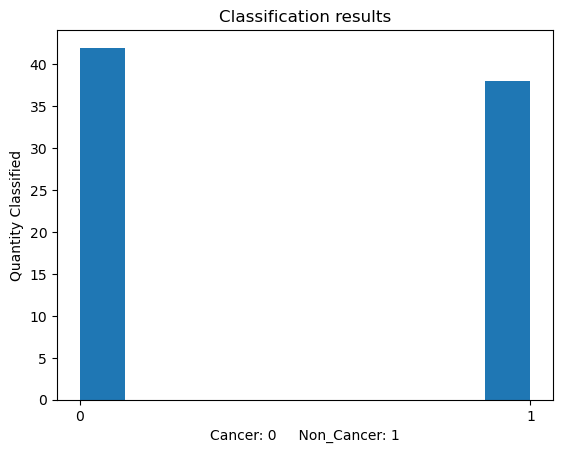

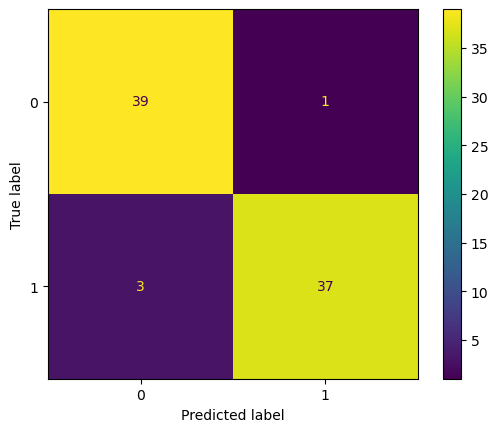

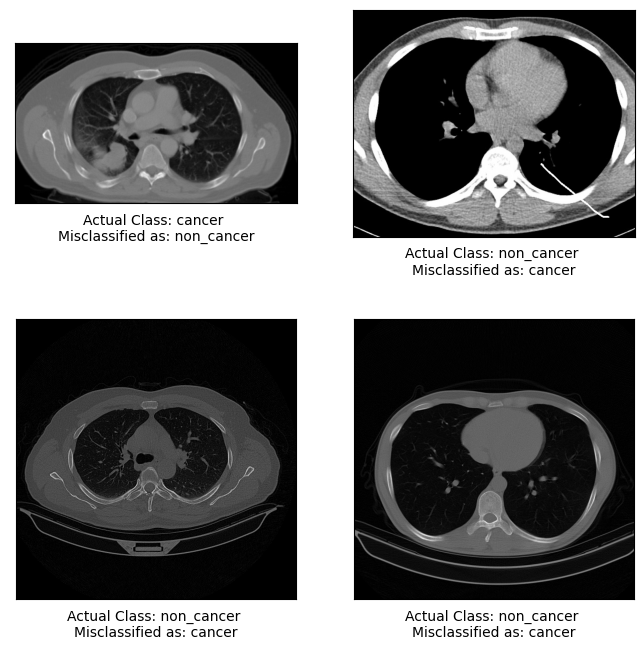

In [18]:
model_results(model4,test_data,test_path)

## Custom Model Results Interpretation:
My custom model takes extreme counteraction to any overfitting with these notable methods:
-	Input Layer:
	- 16 filters, and a batch normalization before the activation. 
-	Hidden Layer
    - With a relatively low neuron count of 64, again the batch normalization comes before the activation which is followed by a dropout penalty of 30%. 
-	Compiling
	- Increased learning rate and halved the batch size.

Only one scan was classified as non-cancerous when it was cancerous. 3 scans were classified as cancerous when they were non-cancerous. While not ideal, the model is performing relatively well, outperforming the baseline by 40% and demonstrating high accuracy and recall.

**It is worth noting** your results may be different than what is depicted here. This is because when training, not only are the images randomly sampled, but the dropout layer drops images at random as well. You may have stronger results, but more likely you will have weaker results. You could use a checkpoint callback that saves the best weights and load the weight onto the saved model. However, it is unlikely this custom model will ever outperform the following models.

## Transfer Learning Models

### ResNet50

In [19]:
def build_resnet50(): # standard ResNet50 setup with minor adjustments
    resnet50 = ResNet50(weights='imagenet', include_top=False)

    input = Input(shape=(256,256,1)) # specifiying image shape and single channel for grayscale 
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = resnet50(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x) # keeping batch normalization before activation
    x = Dropout(0.4)(x) # adding a 40% dropout to counter overfitting
    x = Dense(64, activation='relu')(x) # keeping neuron total on the smaller side to counter overfitting
    x = BatchNormalization()(x) # adding batch normalization after activation to counter overfitting
    x = Dropout(0.4)(x) # 40% dropout as well

    # Output
    output = Dense(1,activation = 'sigmoid')(x)
 

    # model
    model = Model(input,output)
    
    # OPTIMIZATION
    # 𝛽1 and 𝛽2 are initial decay rates used when estimating the first and second moments of the gradient
    # Decreasing 𝛽1 and 𝛽2 of Adam will make the learning slower
    # learning rate will decrease if accuracy shows no improvement after 5 epochs
    opt = tf.keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    
    return model

In [20]:
resnet_model = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)

res_history = resnet_model.fit(
train_data,
batch_size=32,
validation_data=valid_data,
epochs=20,
callbacks=[annealer])

In [21]:
resnet_model.save("models/ResNet50_model.h5")

## ResNet50 Model Results

In [22]:
resnet_model = load_model('models/ResNet50_model.h5')

3/3 [==============================] - 11s 3s/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       0.98      1.00      0.99        40

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



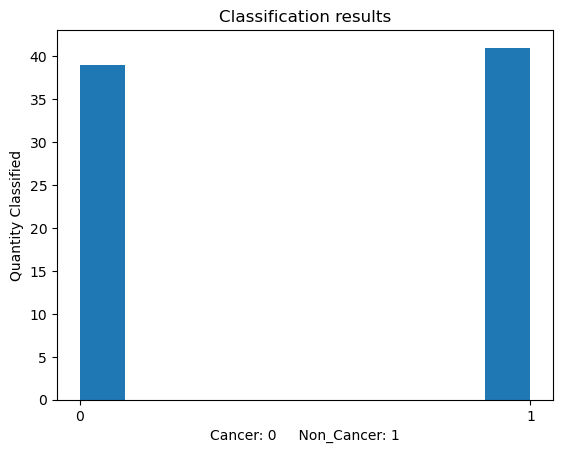

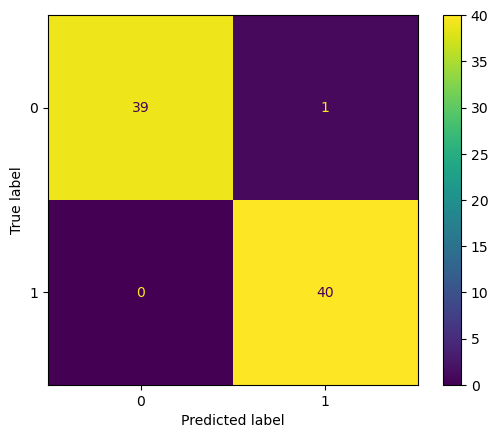

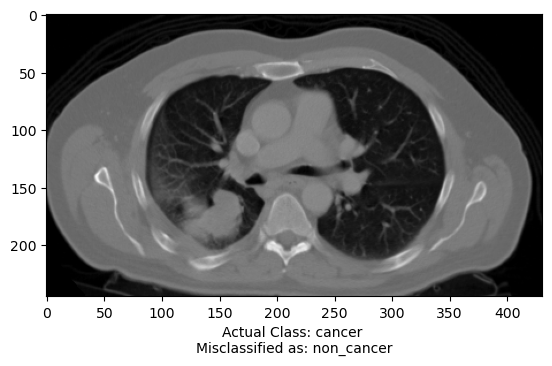

In [23]:
model_results(resnet_model,test_data,test_path)

In [24]:
def plot_loss(history):
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']

    # Set figure size
    plt.figure(figsize=(10, 7))

    # Generate line plot of training, testing loss over epochs
    plt.plot(train_loss, label='Training Loss', color='#185fad')
    plt.plot(test_loss, label='Testing Loss', color='orange')

    # Plot Labels
    plt.title('Training and Testing Loss by Epoch', fontsize = 20)
    plt.xlabel('Epoch', fontsize = 16)
    plt.ylabel('Binary Crossentropy', fontsize = 16)
    plt.xticks(np.arange(20), np.arange(20))

    plt.legend(fontsize = 14);

In [25]:
# This function will work and plot the graph you see below.
# The graph below is a screenshot because this model was performed and transfered from a google colab notebook
# Using colabs GPU helped speed up this process exponentially
plot_loss(res_history)

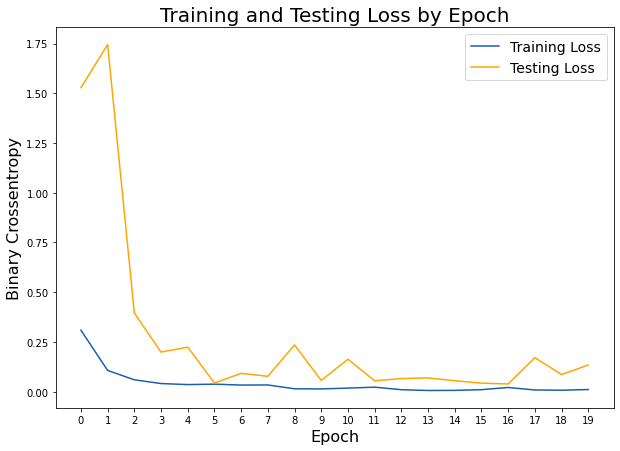

## ResNet50 Results Interpretation
-	The ResNet50 model is not only performing at an ideal level but works well with grayscale images. The only misclassified image was misclassified in my custom model as well. To condense the notebook, I only display the train and testing loss for this model because this model is used in the Streamlit app. After just 5 epochs the ResNet50 model's loss and validation-loss functions reach .1 simultaneously continuing a steady decrease. Additionally, the accuracy and validation-accuracy plateau at 99% each.
-	This performance is ideal because this is a binary problem where it is either cancer or not cancer. Outperforming the baseline by 49% are results I can accept. In practice, that is somebody’s grandma, so achieving a high score where overfitting does not occur is crucial.

### Pickling ResNet50 Model
- This is the model that will be used for the streamlit app.

In [26]:
import pickle
resnet_model = load_model('models/ResNet50_model.h5')
with open('ResNet50_model.pkl','wb')as pickle_out:
    pickle.dump(ResNet50_model, pickle_out)

## VGG16
- VGG16 requies 3 channels so I change the color_mode to rgb in the following cell
- **Note** if you wish to run any model results again at the end of the notebook be mindful of which model and data_gen you are using.  

In [27]:
train_data = train_gen.flow_from_directory(
    train_path,
    class_mode='binary',
    color_mode='rgb') # changing to rgb

valid_data = valid_gen.flow_from_directory(
    valid_path,
    class_mode='binary',
    color_mode='rgb') # changing to rgb
    
test_data = test_gen.flow_from_directory(
    test_path,
    class_mode='binary',
    color_mode='rgb', # changing to rgb
    shuffle=False)

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [28]:
def build_vgg116():
    # Going with a very similar setup to the ResNet Model
    
    VGG = VGG16(weights='imagenet', include_top = False)
    
    # Channel size of 3 to account for RGB
    input = Input(shape=(256, 256, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = VGG(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    
    # lower amount of neurons in this dense hidden layer than ResNet to counter overfitting
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    # there are no dropouts in this model as they shouldn't be needed due to simplicity
    
    output = Dense(1,activation = 'sigmoid')(x)
 

    # model
    model = Model(input,output)
   
    # changing metric to accuracy, partly for experimentation and partly because I believe 
    # this model is constructed simplier than ResNet; may require more active changes to slow the learning rate
    # and ensure the model learns enough from the training data
    opt = tf.keras.optimizers.Adam(learning_rate= 0.003, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0)
    model.compile(loss = 'binary_crossentropy', optimizer=opt, metrics = ['accuracy'])
    model.summary()
    
    return model

In [29]:
vgg16_model = build_vgg116()

vgg_history = vgg16_model.fit(
train_data,
batch_size=32,
validation_data=valid_data,
epochs=30,
callbacks=[annealer])

In [30]:
vgg16_model.save("models/vgg16_model.h5")

## VGG16 Model Results

In [31]:
vgg16_model = load_model('models/vgg16_model.h5')

3/3 [==============================] - 27s 8s/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       0.98      1.00      0.99        40

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



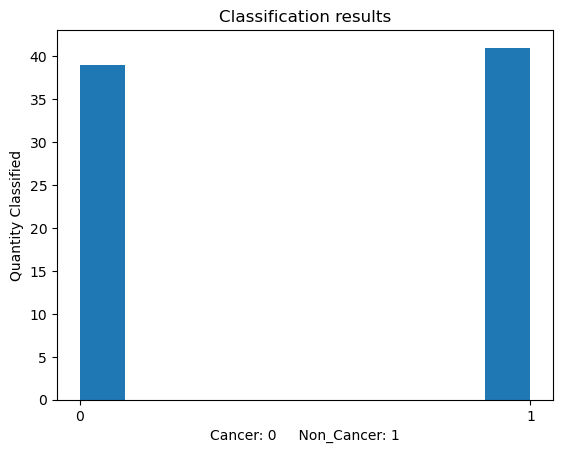

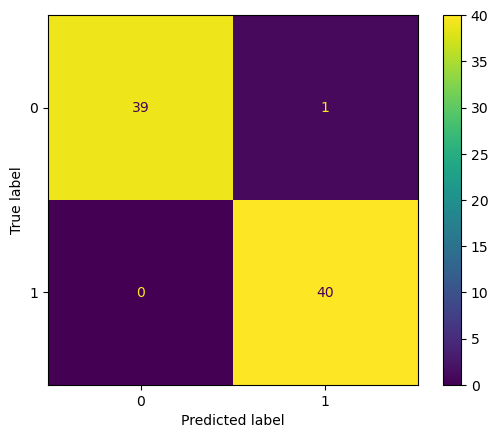

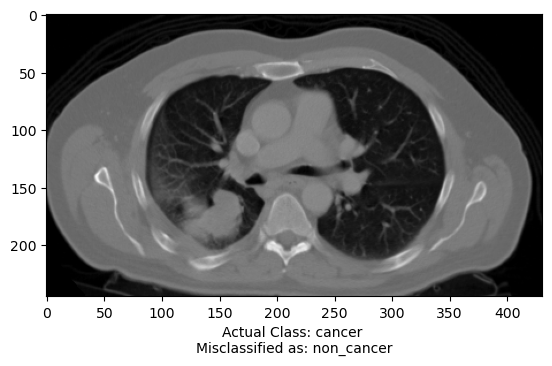

In [32]:
model_results(vgg16_model,test_data,test_path)

## VGG16 Results Interpretation
-	Performing similarly to the ResNet50 model, VGG16 achieves acceptable scores. However, VGG16 does not accept a channel of 1. Having to change the number of channels to 3 by changing the data color mode previously from 'grayscale' to 'rgb' pushes me away from this model despite a strong performance. I'd rather use ResNet50 as all images in the data are already grayscale images. Additionally, I am led to believe there may be an error of sorts with this image that continues to be misclassified.
- The white branches you see in the lungs are called bronchioles. Simply put, brochi carry air into your lungs and lung cancer disrupts this process. In this image, the bottom left of the right lung (left on the image, it's reversed) there is a large mast which is clearly the cancer. 

## MobileNetV2

In [33]:
def build_mobilenet():
    # First two transfer learning models performed exceptionally well
    # Will be using mobile net as more experimentation than anything else
    
    mobile = MobileNetV2(weights='imagenet', include_top=False)

    input = Input(shape=(256, 256, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = mobile(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x) # including dropout penalties in this model
    x = Dense(64, activation='relu')(x) # going back to 64 neurons 
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(1,activation = 'sigmoid')(x)
 

    # model
    model = Model(input,output)
    
    opt = tf.keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    
    return model

In [34]:
mobilenet_model = build_mobilenet()

mobile_history = mobilenet_model.fit(
train_data,
batch_size=32,
validation_data=valid_data,
epochs=30,
callbacks=[annealer])

In [35]:
mobilenet_model.save('models/mobilenet_model.h5')

## MobileNet Model Results

In [36]:
mobilenet_model = load_model('models/mobilenet_model.h5')

3/3 [==============================] - 5s 1s/step
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        40
           1       0.89      1.00      0.94        40

    accuracy                           0.94        80
   macro avg       0.94      0.94      0.94        80
weighted avg       0.94      0.94      0.94        80



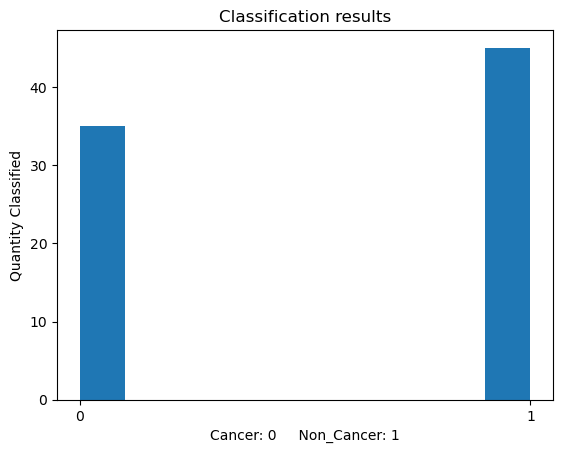

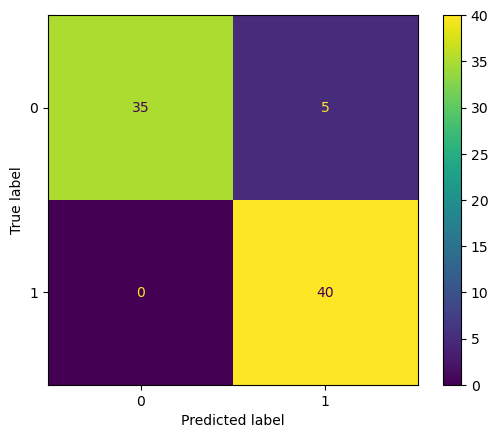

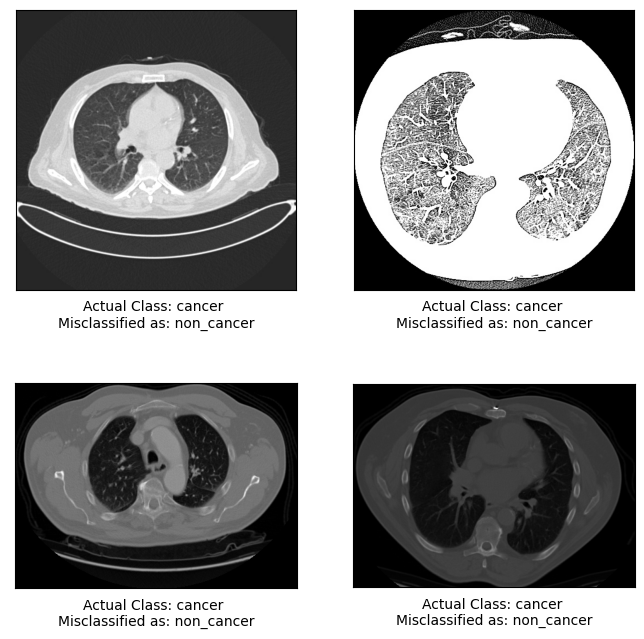

In [37]:
model_results(mobilenet_model,test_data,test_path)

## MobileNetV2 Results Interpretation
MobileNetV2 does a poor job optimizing false negatives as opposed to ResNet50, VGG16, and even my custom model. Additionally, MobileNetV2 demands 3 channels as well so the same changes that were made to VGG16 were made here. This model will not be used. I suspect the poor results are due to user error. The increased dropout penalties and changed learning rate are suspected factors in the models' poor performance. 

## Predicting Any Image

In [41]:
def predict_any_image(filename):
    # this function is specifically designed for the ResNet50 model
    
    np_image = Image.open(filename) # load and transform image
    np_image = np.array(np_image).astype('float32')
    np_image = transform.resize(np_image, (256, 256, 1))
    np_image = np.expand_dims(np_image, axis=0)
    
    prediction = resnet_model.predict(np_image)
    plt.imshow(cv2.imread(filename))
    
    if prediction <=.5:
        plt.xlabel(f"The Model Predicts This Image Displays Cancer\
        \nThe Model is {str(99 - np.round(prediction[0][0]*100)) + '%'} confident in it's prediction")
        
    else:
        plt.xlabel(f"The Model Predicts This Image Does Not Display Cancer\
        \nThe Model is {str(np.round(prediction[0][0]*100)) + '%'} confident in it's prediction")

1/1 [==============================] - 0s 170ms/step


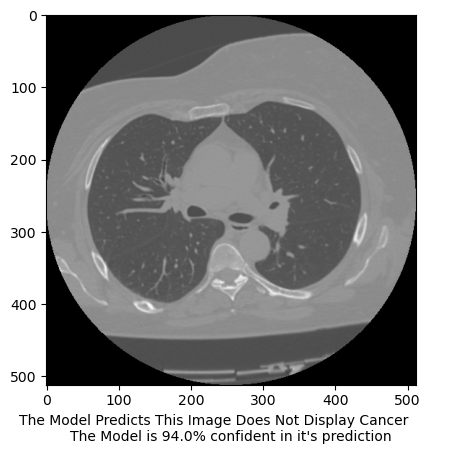

In [42]:
predict_any_image('data/test/non_cancer/16_Morozov_study_0150_29.png')
# Ignore warning as the testing data is small and takes minimal time to execute

1/1 [==============================] - 0s 177ms/step


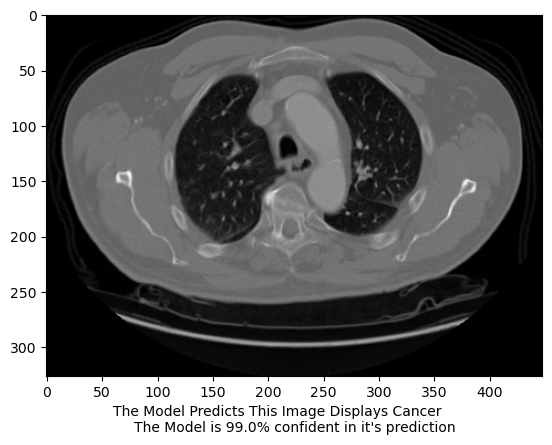

In [43]:
predict_any_image('data/test/cancer/000142 (6).png')

Because a sigmoid output is a probability between 0 and 1 and not a clearly defined 0 or 1, the word confident is meant to summarize this process and probability.

## Conclusion:
- The original problem statement asks if it is possible to accurately classify whether a CT scan displays cancer or not. After constructing many models, I can conclude that it is possible. The ResNet50 model answers this question best, bolstering an accuracy of .99 on the entirety of the testing data as well as a recall of 1.0 and .98 for cancer and non-cancer images respectively. A focus was to minimize false negatives, and the ResNet50 model only misclassified one image. This one image was recurring through all models which leads me to believe there may be an issue with how the image is pre-processed.

- The purpose of this model is to demonstrate the benefits and efficiency that deep learning brings to the healthcare field. You should never base a diagnosis on what a model says. The real-world purpose is for a physician to use a model such as this as a reference. By eliminating cases where both a doctor and the model is confident the patient does not have cancer, they can focus on cases they believe do have cancer. Doing so could save lives and using CT scans has already proven to be the case!

## Recommendations:
- From here, I would mask and segment the lungs. Doing so would allow for a better idea of where cancer could be in the lungs. I attempted to do this however due to time constraints I was unable to complete this task.
- High frequency in file repetition caused a lot of time to be spent looking over the images. To keep the train-validation split at an acceptable rate I ended up having only 80 images to test my model on. I would gather more data and test how my model performs on larger datasets.
- Additionally to segmenting the lungs, training the model to localize where it believes cancer is would be ideal as well. 

##  Streamlit:
- You can try the model out for yourself if you have a streamlit enviornment installed.
- streamlit run app.py
- If you did not run this notebook, the pickled model is included in the repo